In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sci
import scipy.cluster as clus
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from scipy.stats import ttest_ind
pd.options.mode.chained_assignment = None #avoids SettingWithCopyWarning given when adding columns age, month and week
df = pd.read_csv('../AB_Testing/LV_quotes_radio_campaign_v2.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['dateofbirth'] = pd.to_datetime(df['dateofbirth'])
df['policy_start_date'] = pd.to_datetime(df['policy_start_date'])
df.dropna(inplace=True)

cutoff_pd = pd.to_datetime("05/01/2019 00:00")

In [2]:
df

,quote_number,timestamp,channel,region,dateofbirth,license_years,num_convictions,num_fault_claims,make,model,manfyear,purchaseyear,fuel_type,transmission_type,payment_plan,nature_of_use,overnightparking_loc,policy_start_date,premium,converted
0,20886,2019-10-04 23:44:00,Google,BRISTOL,1965-01-12,31.0,0,0,YAMAHA,MT-03,2008.0,2012.0,petrol,automatic,annual,social-domestic-pleasure(sdp),unsecured_car_park,2019-10-04,85.94,1
1,7708,2019-03-28 03:37:00,Go Compare,BRISTOL,1960-01-07,40.0,0,0,YAMAHA,XJR 1300,2012.0,2012.0,electric,manual,annual,sdp-plus-commuting,garage,2019-03-28,127.21,0
2,14029,2019-04-26 07:31:00,Money Supermarket,BRISTOL,1963-08-12,36.0,0,1,HONDA,CB 650F (86HP),2015.0,2017.0,petrol,manual,annual,sdp-plus-commuting,drive,2019-05-15,249.56,1
3,31967,2019-02-22 15:39:00,Google,BRISTOL,1984-04-25,15.0,0,0,TOYOTA,GT86 AERO,2015.0,2015.0,petrol,automatic,annual,sdp-plus-commuting,secured_car_park,2019-02-03,512.52,0
4,36352,2019-04-21 11:02:00,Compare the market,BRISTOL,1987-07-23,13.0,0,0,SMART,PASSION CABRIOLET AUTO,2003.0,2018.0,diesel,automatic,annual,sdp-plus-business,unsecured_car_park,2019-08-05,345.33,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,6592990,2019-11-08 18:30:00,Web,SOUTHAMPTON,1960-02-16,40.0,0,0,AUDI,A6 SE TDI AUTO,2007.0,2014.0,petrol,automatic,annual,social-domestic-pleasure(sdp),road,2019-08-13,435.04,1
99996,10588592,2019-12-07 16:42:00,Money Supermarket,EDINBURGH,1990-12-20,8.0,0,0,Mazda,6 TS,2003.0,2011.0,diesel,automatic,annual,sdp-plus-business,drive,2019-07-31,254.71,1
99997,1855462,2019-07-21 18:32:00,Confused,BIRMINGHAM,1965-05-24,35.0,0,1,VW,POLO S 16V,2006.0,2011.0,petrol,automatic,annual,sdp-plus-commuting,drive,2019-07-31,408.49,0
99998,3072180,2019-07-13 06:34:00,Confused,LEICESTER,1980-06-22,19.0,0,0,HYUNDAI,I10 CLASSIC (85),2012.0,2012.0,diesel,automatic,annual,social-domestic-pleasure(sdp),garage,2019-07-31,178.05,1


In [48]:
# adapts data for use - limits to region, adds week and month of timestamp, adds car and channel labels
# returns original df with added columns

def data_adapt(df, region, all=False):
    if all == False:
        df_region = df[df["region"]==region]
    else:
        df_region = df
    now = pd.Timestamp('now')
    df_region["age"] = (now - df_region['dateofbirth']).astype('<m8[Y]')
    df_region["week_no"] = pd.to_datetime(df_region["timestamp"]).dt.week
    df_region["month_no"] = pd.to_datetime(df_region["timestamp"]).dt.month
    # Add labels for car ranking
    df_region["make_ranking"] = np.nan
    cars_ranking = ["Mercedes", "BMW" , "Volvo" , "Audi" , "VW" , "Nissan" , "Ford" , "Peugeot" , "Toyota" , "Seat" , "Skoda" , "Kia" , "Renault" , "Opel" , "Hyundai" , "Citroen" , "Fiat" , "Dacia"]
    df_region["make"] = df_region.make.str.upper()
    cars_ranking = [x.upper() for x in cars_ranking] 
    for i in range(len(cars_ranking)):
        df_region.loc[df_region["make"] == cars_ranking[i], "make_ranking"] = (i+1)
    
    # Add labels for channel
    channels_class1 = ["Call Centre", "Web"]
    channels_class2 = ["Confused", "Money Supermarket", "Go Compare", "Compare the market"] 
    channels_class3 = ["Google"]
    for i in range(len(channels_class1)):
        df_region.loc[df_region["channel"] == channels_class1[i], "channel_label"] = 1
    for i in range(len(channels_class2)):
        df_region.loc[df_region["channel"] == channels_class2[i], "channel_label"] = 2
    for i in range(len(channels_class3)):
        df_region.loc[df_region["channel"] == channels_class3[i], "channel_label"] = 3
    
    # Add labels for transmission
    df_region["transmission_label"] = np.nan
    transmissions = ["automatic", "manual"]
    for i in range(len(transmissions)):
        df_region.loc[df_region["transmission_type"] == transmissions[i], "transmission_label"] = (i+1)

    # Add labels for fuel
    df_region["fuel_label"] = np.nan
    fuels = ["diesel", "petrol", "electric"]
    for i in range(len(fuels)):
        df_region.loc[df_region["fuel_type"] == fuels[i], "fuel_label"] = (i+1)

    # Add labels for use
    df_region["use_label"] = np.nan
    uses = ["sdp-plus-business","social-domestic-pleasure(sdp)",  "sdp-plus-commuting"]
    for i in range(len(uses)):
        df_region.loc[df_region["nature_of_use"] == uses[i], "use_label"] = (i+1)
        
    df_region = df_region.dropna()
    return df_region

In [49]:
# clusters dataframe in groups given the input features (as matrix)
# returns original df with added column labels (labels from 1 to num_centroids)
def clustering(df, num_centroids, features):
    df_clustering = df.loc[:,[features[0]]]
    for i in range(len(features)-1):
        df_clustering[features[i+1]] = df.loc[:,[features[i+1]]]
    
    kmeans = KMeans(num_centroids).fit(df_clustering)
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_
    df["labels"] = labels    
    return df

def cluster_optimise(df, range_num_centroids, features):
    sil_score =  np.zeros(np.shape(range_num_centroids))
    counter = 0;
    df_clustering = df.loc[:,[features[0]]]
    for num_centroids in range_num_centroids:
        for i in range(len(features)-1):
            df_clustering[features[i+1]] = df.loc[:,[features[i+1]]] 
        kmeans = KMeans(num_centroids).fit(df_clustering)
        labels = kmeans.labels_
        
        sil_score[counter] = silhouette_score(df_clustering, labels)
        counter = counter +1

    print(sil_score)
    return 0

In [50]:
from scipy.stats import ttest_ind
# Runs t-test on df before and after cutoff, returns 1 if singificant or 0 if not
# optional "print" turns on printing result

def t_test(df, cutoff, prints = True):
    """
    Function to compute a t-test to sde if the mean conversion rate
    changes after the advert is played. Null hypothesis is that the advert 
    does nothing. Assuming independence between samples (dodgy)
    NOTE: here used for subsets of Bristol data so df=df_reg
    """
    cutoff = pd.to_datetime(cutoff)

    df_before = df[df['timestamp']< cutoff_pd]
    df_after = df[df['timestamp']> cutoff_pd]
    
    p_val = ttest_ind(df_before['converted'], df_after['converted'])[1]
    
    if p_val > 0.05:
        if prints == True:
            print("non-significant")
        return 0
    else:
        if prints == True:
            print("SIGNIFICANT")
        return 1
    
# Runs control chart before and after cutoff.
# Plots if plot = true, prints all results if prints = true, prints only significant increases if summary = true
# returns matrix, rows are each month after cutoff. First column is month number, second column is change in
# number of conversions (1 if signficant increase, 0 if non significant, -1 if significant decrease),
# third column is change in quote requests, fourth is change in conversion rate

def control_chart_significance(df, cutoff, plot = False, prints = True, summary = False):
    cutoff = pd.to_datetime(cutoff)
    df_before = df[df['timestamp']< cutoff_pd]
    df_after = df[df['timestamp']> cutoff_pd]
    
    if len(df) == 0:
        return np.zeros((4,8))
    
    df_month_total = df.groupby('month_no')['converted'].value_counts().unstack()
    df_month_pct = df.groupby('month_no')['converted'].value_counts(normalize=True).unstack()*100
    df_month_count = df.month_no.value_counts().sort_index()
    
    if len(df_before) > 0 and len(df_after) > 0 :
        before_count_months = (df_before.groupby('month_no')['converted'].value_counts().unstack())
        before_count_months_pct = (df_before.groupby('month_no')['converted'].value_counts(normalize=True).unstack())*100

        after_count_months = (df_after.groupby('month_no')['converted'].value_counts().unstack()) 
        after_count_months_pct = (df_after.groupby('month_no')['converted'].value_counts(normalize=True).unstack())*100
        
        
    else:
        return np.zeros((4,np.shape(df_month_total))[0])
 
    
    
    mean0 = np.mean(before_count_months[0]) ; mean1 = np.mean(before_count_months[1])
    sem0 = sci.sem(before_count_months[0]) ; sem1 = sci.sem(before_count_months[1])
    mean_all = np.mean(df_month_count) ; sem_all = sci.sem(df_month_count)

    mean0per = np.mean(before_count_months_pct[1]) ; sem0per = sci.sem(before_count_months_pct[1])
    
    results = np.zeros((4,np.shape(after_count_months)[0]))
    
    for i in range(np.shape(after_count_months)[0]):
        results[0, i] = i+cutoff.month
        if prints == True:
            print("Month ", i+cutoff.month, " shows:")
        if np.any(after_count_months.iloc[i, 1]>(mean1+2.5*sem1)):
            if prints == True:
                print("- significant INCREASE in conversions")
            results[1,i] = 1
        if (np.any(after_count_months.iloc[i,1]<(mean1-2.5*sem1))): 
            if (prints == True and summary == False):
                print("- significant decrease in conversions")
            results[1,i] = -1
        if np.any((after_count_months.iloc[i,0]+after_count_months.iloc[i,1])>(mean_all +2.5*sem_all)):
            if prints == True:
                print("- significant INCREASE in number of overall quote requests") 
            results[2,i] = 1
        if (np.any((after_count_months.iloc[i,0]+after_count_months.iloc[i,1])<(mean_all +2.5*sem_all))):
            if (prints == True and summary == False) :
                print("- significant decrease in number of overall quote requests") 
            results[2,i] = -1
        if np.any(after_count_months_pct.iloc[i,1]>(mean0per+2.5*sem0per)):
            if prints == True:
                print("- significant INCREASE in conversion rate")
            results[3,i] = 1
        if np.any(after_count_months_pct.iloc[i,1]<(mean0per+2.5*sem0per)):
            if (prints == True and summary == False):
                print("- significant decrease in conversion rate")
            results[3,i] = -1
            
    if plot == True:
        fig, (ax1,ax2, ax3) = plt.subplots(3,1,figsize=(15,7))
        colores = ['DarkOrange', 'DarkBlue']
        df_month_total.plot(color=colores,ax=ax1, linewidth=4)
        ax1.set_title('Control chart with monthly count of conversions vs non-conversions (Jan to Dec)\n Black line indicates advert release', fontsize = 15)
        ax1.axvline(color='Black',x=cutoff.month)
        ax1.axhline(color='Orange', y=mean0)
        ax1.axhline(color='Orange', y=mean0-2.5*sem0)
        ax1.axhline(color='Orange', y=mean0+2.5*sem0)

        ax1.axhline(color='DarkBlue', y=mean1)
        ax1.axhline(color='DarkBlue', y=mean1-2.5*sem1)
        ax1.axhline(color='DarkBlue', y=mean1+2.5*sem1)
        ax1.set_xlabel("Month", fontsize = 15)

        df_month_pct[1].plot(color="Orange",ax=ax2, linewidth=4)
        ax2.set_title('Control chart with monthly rate of conversion vs non-conversions (Jan to Dec)\n Black line indicates advert release', fontsize = 15)
        ax2.axvline(color='Black',x=cutoff.month)
        ax2.axhline(color='Orange', y=mean0per)
        ax2.axhline(color='Orange', y=mean0per-2.5*sem0per)
        ax2.axhline(color='Orange', y=mean0per+2.5*sem0per)

        ax2.set_xlabel("Month", fontsize = 15)
        
        df_month_count.plot(color="Green", ax=ax3, linewidth=4)
        ax3.set_title('Control chart with Absolute number of requests (Jan to Dec)\n Black line indicates advert release', fontsize = 15)
        ax3.axvline(color='Black',x=cutoff.month)
        ax3.axhline(color='Green', y=mean_all)
        ax3.axhline(color='Green', y=mean_all-2.5*sem_all)
        ax3.axhline(color='Green', y=mean_all+2.5*sem_all)        

        plt.tight_layout()
    
    return results

In [51]:
# retuns a table with the characteristics of each group (df_groups) and a table with 
# the relevance results of each group (df_results). 
# Right now it is set to only return groups. Should maybe be changed so only group characterisation is returned?
def summary_print(num_centroids, features, df_labeled):
    #df_results = pd.DataFrame()
    columns2 = ["group", "feature","mean", "std"] 
    df_groups = pd.DataFrame(columns = columns2)
    for i in range(num_centroids):
        new_group = df_labeled[df_labeled["labels"] == i]
        for j in range(len(features)):
            df_groups = df_groups.append({"group" : i, "feature" : features[j] ,"mean" : new_group[features[j]].mean() , "std" : new_group[features[j]].std()}, ignore_index=True)  
        #t_test_result = t_test(new_group, "05/01/2019 00:00", prints=False)
        #control_results = control_chart_significance(new_group, "05/01/2019 00:00", plot=False, prints = False, summary = True)
        #columns = ["month_no","conversion_num", "quote_requests", "conversion_rate"]
        #control_results = pd.DataFrame(control_results.T, columns = columns)
        #control_results = control_results.T
        #control_results["t-test"] = t_test_result
        #control_results["group"] = i
        #df_results = df_results.append(control_results,ignore_index=True)
    return df_groups #, df_results

In [52]:

def representative_clusters(df_labeled, df_all, cities_to_compare, features, prints = False):
    """we want to go through each group, find a similar group for the uk and specific cities before the advert, 
    test if rates of quote requests are significant.
    Both inputted dfs should be adapted beforehand, df_labeled should be labeled. Cities to compare should have 
    "all" as first entry"""
    
    clusters_rep = [df_labeled[df_labeled['labels']==i] for i in range(5)]
    results = pd.DataFrame(columns = cities_to_compare)
    for group in clusters_rep:
        res_for_group = []
        for region in cities_to_compare:
            if region == "all":
                df_region = df_all
            else:
                df_region = df_all[df_all["region"] == region]
                
            for f in range(len(features)):
                df_mean = group[features[f]].mean() ; df_std = group[features[f]].std()
                group_compare = df_region[df_region[features[f]]<df_mean+df_std]
                group_compare = group_compare[group_compare[features[f]]>df_mean-df_std]
    
            p_val = ttest_ind(group['converted'], group_compare['converted'])[1]
            res_for_group.append(p_val)
        results.loc[len(results)] = res_for_group
    
    return results
        
        
            
    

In [39]:
df_bris = data_adapt(df, 'LONDON')
df_all = df[df["region"]!="LONDON"]
df_all = data_adapt(df_all, 'BRISTOL', True)
cities = ["all", "BRISTOL", "MANCHESTER", "LIVERPOOL", "NOTTINGHAM", "BIRMINGHAM"]
features = ["age", "make_ranking"]
cutoff = pd.to_datetime("05/01/2019 00:00")
df_bris_before = df_bris[df_bris['timestamp']<cutoff]
df_all = df_all[df_all['timestamp']<cutoff]
bristol_clustered = clustering(df_bris_before, 5, features) 

representative_clusters(bristol_clustered, df_all, cities, features)

,all,BRISTOL,MANCHESTER,LIVERPOOL,NOTTINGHAM,BIRMINGHAM
0,2.257820e-01,8.491361e-01,5.208458e-03,2.444021e-01,2.134467e-01,1.999830e-02
1,2.122743e-31,4.518360e-34,7.933553e-17,1.150110e-24,1.486113e-20,1.113666e-16
2,4.491469e-16,3.749241e-12,3.246251e-17,1.370894e-12,1.821686e-12,1.796891e-14
3,5.909858e-09,3.143974e-10,1.323939e-02,1.193968e-05,2.220561e-04,2.442685e-06
4,3.866146e-10,3.749824e-12,6.671152e-04,1.361674e-06,2.807886e-05,1.292941e-03


In [38]:
summary_print(5, features, bristol_clustered)

,group,feature,mean,std
0,0,age,23.590062,3.118953
1,0,make_ranking,7.511387,4.639870
2,1,age,54.666045,2.848585
3,1,make_ranking,8.630597,4.805538
4,2,age,44.845652,2.979246
5,2,make_ranking,6.973913,4.484708
6,3,age,64.503704,3.128952
7,3,make_ranking,6.994444,4.439865
8,4,age,34.108963,2.938107
9,4,make_ranking,6.989455,4.192955


In [ ]:
#plotting most significant groups 

In [53]:
# using clustered data as input, finds similar groups in another region. Runs t-tests and control chart
# and compares significant changes in similar groups. Prints successes if prints = True.
# returns table with relevance results for each group and month 
# (1 if significant in labeled and not in region to compare, 0 otherwise) 
def city_comparison(df_labeled, region_to_compare, features, num_centroids, cutoff, prints = False):
    cutoff = pd.to_datetime(cutoff)
    df_compare = data_adapt(df, region_to_compare)
    df_comparison_results = pd.DataFrame()
    
    for i in range(num_centroids):
        if prints == True:
            print("For Group", i)
        new_group = df_labeled[df_labeled["labels"] == i] 
        
        # find group in region to compare with same characteristics as labeled data
        for f in range(len(features)):
            df_mean = new_group[features[f]].mean() ; df_std = new_group[features[f]].std()
            group_compare = df_compare[df_compare[features[f]]<df_mean+df_std]
            group_compare = group_compare[group_compare[features[f]]>df_mean-df_std]     

        # compare control charts for each month  
        columns = ["month_no","conversion_num", "quote_requests", "conversion_rate"]
        compare_results = pd.DataFrame(columns = columns)
        control_new_group = control_chart_significance(new_group, cutoff, plot=False, prints = False, summary = True)
        control_compare = control_chart_significance(group_compare, cutoff, plot=False, prints = False, summary = True)
        for n in range(np.shape(control_new_group)[1]): #for each month
            success = np.zeros((1,3))
            if prints == True:
                print("Month ", n+cutoff.month, " shows:")
            if ((control_new_group[1,n] == 1) & (control_new_group[1,n] > control_compare[1,n])):
                if prints == True:
                    print("SUCCESS - labeled data shows significant increase in conversions but other region doesnt") 
                success[0,0] = 1
            if ((control_new_group[2,n] == 1) & (control_new_group[2,n] > control_compare[2,n])):
                if prints == True:
                    print("SUCCESS - labeled data shows significant increase in number of quote requests but other region doesnt")
                success[0,1] = 1
            if ((control_new_group[3,n] == 1) & (control_new_group[3,n] > control_compare[3,n])):
                if prints == True:
                    print("SUCCESS - labeled data shows significant increase in conversion rate but other region doesnt")
                success[0,2] = 1
            compare_results = compare_results.append({"month_no" : n+cutoff.month ,"conversion_num": success[0,0] ,"quote_requests" : success[0,1],"conversion_rate" : success[0,2]}, ignore_index=True)
            #if (control_new_group[0,i] == 0 & control_new_group[0,i] == control_compare[0,i]):
            #    print("Both regions have non-significant changes in conversion number")
            #if (control_new_group[1,i] == 0 & control_new_group[1,i] == control_compare[1,i]):
            #    print("Both regions have non-significant changes in quote requests number number") 
        
        #compare t test results
        t_new_group = t_test(new_group, "05/01/2019 00:00", prints = False)
        t_compare = t_test(group_compare, "05/01/2019 00:00", prints = False)
         
        # df_groups = df_groups.append({"group" : i, "feature" : features[j] ,"mean" : new_group[features[j]].mean() , "std" : new_group[features[j]].std()}, ignore_index=True) 
        if (t_new_group == t_compare & t_new_group == 1):
            if prints == True:
                print("This group shows singificant changes in both cities")
            compare_results["t-test"] = 0
        if (t_new_group == t_compare & t_new_group == 0):
            if prints == True:
                print("This group does not show singificant changes in either cities")
            compare_results["t-test"] = 0
        if (t_new_group > t_compare):
            if prints == True:
                print("SUCCESS - labeled data shows significant change but the other region doesnt")
            compare_results["t-test"] = 1
        if (t_new_group < t_compare):
            if prints == True:
                print("labeled data shows no significant change but the other region does")  
            compare_results["t-test"] = 0
        compare_results["group"] = i    
        if prints == True:
            print("\n")
        df_comparison_results = df_comparison_results.append(compare_results,ignore_index=True)
    return df_comparison_results

Pseudocode for group_and_city_comparisons:

for each number of clusters
 
    - bristol is clustered
    - for each cluster:
        - for each region in regions_to_compare:
            - find group in region with similar characteristics to cluster
            - find the significance results
        - add up significant results of each region, producing "significance score" for each cluster
    - for each number of clusters, produce ranking of clusters according to their score
    - return characteristics of most significant clusters

In [54]:
#plot == True plots two graphs
# first, plots age and carmake for the two most relevant clusters for each cluster number
#second, plots age and carmake for any cluster with significant relevance => 3* number of cities 

#features MUST have age and carmake first
def group_and_city_comparisons(df_adapted, regions_to_compare, features, range_num_centroids, cutoff, prints = True, plot = False):
    if plot == True:
        fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15,7))
        ax1.set(xlim=(18, 70), ylim=(0, 18))
        ax2.set(xlim=(18, 70), ylim=(0, 18))
        ax1.set_title("Two most relevant clusters for each cluster number", fontsize = 16)
        ax2.set_title("Clusters with relevance higher than boundary", fontsize = 16)
        ax1.set_ylabel("Age", fontsize = 12)
        ax2.set_ylabel("Age", fontsize = 12)
        ax1.set_xlabel("Car Make Ranking", fontsize = 12)
        ax2.set_xlabel("Car Make Ranking", fontsize = 12)
        counter = 0
        colours = ["r", "b", "purple", "g", "brown", "gold"]
     
    relevant_clusters = pd.DataFrame()
    
    for centroids in range_num_centroids:
        # clusters and labels input data for given number of centroids
        df_labeled = clustering(df_adapted, centroids, features)
        
        # create comparison df for each city, add them all up
        df_compare_sum = city_comparison(df_labeled, regions_to_compare[0], features, centroids, cutoff, prints = False)
        for region in regions_to_compare[1:]:
            df_compare_new = city_comparison(df_labeled, region, features, centroids, cutoff, prints = False)
            df_compare_sum.iloc[:,1:5] = df_compare_sum.iloc[:,1:5] + df_compare_new.iloc[:,1:5]

        
        group_totals = np.zeros((1, centroids))
        for group_num in range(centroids):
            group_results = df_compare_sum[df_compare_sum["group"] == group_num]
            group_results = group_results.iloc[:,1:5]
            group_results = group_results.sum(axis=0)
            results = group_results.sum(axis=0)
            group_totals[0,group_num] = results
        
        #identify group that had more significant comparisons to the other regions and its score
        group_totals_sorted = np.sort(group_totals)
        group_totals_indexes = np.argsort(group_totals)
        best_group = group_totals_indexes[0,-1] ; best_score = group_totals_sorted[0,-1]
        best_group2 = group_totals_indexes[0,-2] ; best_score2 = group_totals_sorted[0,-2]
        
        group_characterisation = summary_print(centroids, features, df_labeled)
        best_group_characteristics = group_characterisation[group_characterisation["group"] == best_group]
        best_group2_characteristics = group_characterisation[group_characterisation["group"] == best_group2]
        
        results = pd.DataFrame()
        if best_score >= 3 * len(regions_to_compare):
            print(best_score)
            results = results.append(best_group_characteristics, ignore_index=True)
            if best_score2 >= 3 * len(regions_to_compare):
                print(best_score2)
                results = results.append(best_group2_characteristics, ignore_index=True)
            results["num_clusters"] = centroids
        relevant_clusters = relevant_clusters.append(results, ignore_index = True)
        
        
        if plot == True:
            best_group_characteristics = best_group_characteristics.set_index("feature")
            best_group2_characteristics = best_group2_characteristics.set_index("feature")
            ax1.errorbar(best_group_characteristics.loc["age", "mean"],best_group_characteristics.loc["make_ranking", "mean"],
                         yerr=best_group_characteristics.loc["make_ranking", "std"], xerr=best_group_characteristics.loc["age", "std"],
                        ecolor = colours[counter] )
            ax1.errorbar(best_group2_characteristics.loc["age", "mean"],best_group2_characteristics.loc["make_ranking", "mean"],
                         yerr=best_group2_characteristics.loc["make_ranking", "std"], xerr=best_group2_characteristics.loc["age", "std"],
                        ecolor = colours[counter])
            
            if best_score >= 3 * len(regions_to_compare):
                ax2.errorbar(best_group_characteristics.loc["age", "mean"],best_group_characteristics.loc["make_ranking", "mean"], 
                             yerr=best_group_characteristics.loc["make_ranking", "std"], xerr=best_group_characteristics.loc["age", "std"],
                            ecolor = colours[counter])
            if best_score2 >= 3 * len(regions_to_compare):   
                ax2.errorbar(best_group2_characteristics.loc["age", "mean"],best_group2_characteristics.loc["make_ranking", "mean"],
                             yerr=best_group2_characteristics.loc["make_ranking", "std"], xerr=best_group2_characteristics.loc["age", "std"],
                            ecolor = colours[counter])
            counter = counter +1
            
        if prints == True:
            print("for ", centroids, "clusters")
            print("best group is ", best_group, "with score", best_score)
            print("and characteristics:")
            print(best_group_characteristics)
            print("\n")
            print("second best group is ", best_group2, " with score", best_score2)
            print("and characteristics:")
            print(best_group2_characteristics)
            print("\n")
            print("The other scores are:", group_totals)
            print("\n")
    
    
    if plot == True:
        plt.tight_layout()
    
    return relevant_clusters

In [55]:
df_bris = data_adapt(df, "BRISTOL")
df_bris

,quote_number,timestamp,channel,region,dateofbirth,license_years,num_convictions,num_fault_claims,make,model,...,premium,converted,age,week_no,month_no,make_ranking,channel_label,transmission_label,fuel_label,use_label
3,31967,2019-02-22 15:39:00,Google,BRISTOL,1984-04-25,15.0,0,0,TOYOTA,GT86 AERO,...,512.52,0,35.0,8,2,9.0,3.0,1.0,2.0,3.0
6,25654,2019-03-04 14:09:00,Web,BRISTOL,1964-04-22,37.0,0,0,SEAT,IBIZA CONNECT TSI 89,...,402.87,0,55.0,10,3,10.0,1.0,2.0,1.0,3.0
7,28400,2019-07-02 13:39:00,Call Centre,BRISTOL,1996-12-14,3.0,0,0,VW,UP! WHITE,...,417.40,0,22.0,27,7,5.0,1.0,2.0,2.0,3.0
9,48662,2019-04-26 13:27:00,Call Centre,BRISTOL,1965-02-13,34.0,0,0,MERCEDES,E 250 AVANTGARDE BLUEEFFICIENCY CDI AUTO,...,394.05,1,54.0,17,4,1.0,1.0,1.0,3.0,3.0
10,29037,2019-09-04 02:30:00,Web,BRISTOL,1964-11-22,35.0,0,1,BMW,R1200 C,...,86.39,1,55.0,36,9,2.0,1.0,1.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64632,14282691,2019-08-28 12:13:00,Google,BRISTOL,1949-07-04,52.0,0,1,NISSAN,MICRA ACENTA,...,176.20,0,70.0,35,8,6.0,3.0,1.0,2.0,3.0
64636,14414911,2019-06-18 16:01:00,Confused,BRISTOL,1974-11-24,26.0,0,0,TOYOTA,YARIS SR D4D AUTO,...,736.35,0,45.0,25,6,9.0,2.0,1.0,2.0,1.0
64638,14549618,2019-02-06 22:46:00,Call Centre,BRISTOL,1978-08-24,21.0,0,0,FORD,FIESTA TITANIUM (99),...,364.58,0,41.0,6,2,7.0,1.0,1.0,1.0,3.0
64639,14552607,2019-09-07 03:17:00,Compare the market,BRISTOL,1950-06-06,50.0,0,0,AUDI,A4 S LINE 35 TFSI 150,...,311.67,0,69.0,36,9,4.0,2.0,1.0,2.0,3.0


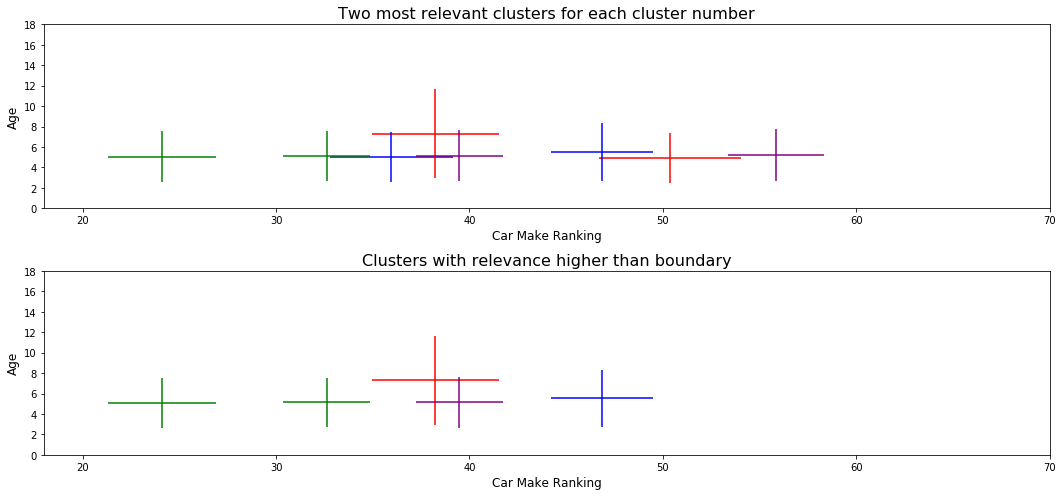

In [11]:
features = np.array(["age", "make_ranking", "channel_label"])
regions_to_compare = ["LONDON", "MANCHESTER", "LIVERPOOL", "NOTTINGHAM", "BIRMINGHAM"]
range_num_centroids = [5,7,9,11]
res = group_and_city_comparisons(df_bris, regions_to_compare, features, range_num_centroids, "05/01/2019 00:00", prints = False, plot = True)

In [56]:
df_bris = data_adapt(df, 'BRISTOL')
df_bris

,quote_number,timestamp,channel,region,dateofbirth,license_years,num_convictions,num_fault_claims,make,model,...,premium,converted,age,week_no,month_no,make_ranking,channel_label,transmission_label,fuel_label,use_label
3,31967,2019-02-22 15:39:00,Google,BRISTOL,1984-04-25,15.0,0,0,TOYOTA,GT86 AERO,...,512.52,0,35.0,8,2,9.0,3.0,1.0,2.0,3.0
6,25654,2019-03-04 14:09:00,Web,BRISTOL,1964-04-22,37.0,0,0,SEAT,IBIZA CONNECT TSI 89,...,402.87,0,55.0,10,3,10.0,1.0,2.0,1.0,3.0
7,28400,2019-07-02 13:39:00,Call Centre,BRISTOL,1996-12-14,3.0,0,0,VW,UP! WHITE,...,417.40,0,22.0,27,7,5.0,1.0,2.0,2.0,3.0
9,48662,2019-04-26 13:27:00,Call Centre,BRISTOL,1965-02-13,34.0,0,0,MERCEDES,E 250 AVANTGARDE BLUEEFFICIENCY CDI AUTO,...,394.05,1,54.0,17,4,1.0,1.0,1.0,3.0,3.0
10,29037,2019-09-04 02:30:00,Web,BRISTOL,1964-11-22,35.0,0,1,BMW,R1200 C,...,86.39,1,55.0,36,9,2.0,1.0,1.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64632,14282691,2019-08-28 12:13:00,Google,BRISTOL,1949-07-04,52.0,0,1,NISSAN,MICRA ACENTA,...,176.20,0,70.0,35,8,6.0,3.0,1.0,2.0,3.0
64636,14414911,2019-06-18 16:01:00,Confused,BRISTOL,1974-11-24,26.0,0,0,TOYOTA,YARIS SR D4D AUTO,...,736.35,0,45.0,25,6,9.0,2.0,1.0,2.0,1.0
64638,14549618,2019-02-06 22:46:00,Call Centre,BRISTOL,1978-08-24,21.0,0,0,FORD,FIESTA TITANIUM (99),...,364.58,0,41.0,6,2,7.0,1.0,1.0,1.0,3.0
64639,14552607,2019-09-07 03:17:00,Compare the market,BRISTOL,1950-06-06,50.0,0,0,AUDI,A4 S LINE 35 TFSI 150,...,311.67,0,69.0,36,9,4.0,2.0,1.0,2.0,3.0


In [75]:
features = ["age", "make_ranking"]
df_labeled = clustering(df_bris, 9, features)
groups = summary_print(9, features, df_labeled)
print(groups)
clusters_rep = [df_labeled[df_labeled['labels']==i] for i in range(9)]
for cluster in clusters_rep:
        res = control_chart_significance(cluster, "05/01/2019 00:00", plot = False, prints = False, summary = True)
        print(res)

   group       feature       mean       std
0      0           age  39.473971  2.243464
1      0  make_ranking   5.206129  2.559317
2      1           age  55.836571  2.496211
3      1  make_ranking   5.174286  2.507473
4      2           age  23.314253  2.546754
5      2  make_ranking   7.720092  4.294441
6      3           age  31.286151  2.501011
7      3  make_ranking   5.001311  2.550795
8      4           age  61.875826  3.948667
9      4  make_ranking  13.779392  2.511878
10     5           age  35.522613  3.921787
11     5  make_ranking  13.969849  2.432528
12     6           age  49.206952  3.394745
13     6  make_ranking  13.570588  2.505017
14     7           age  47.501078  2.188143
15     7  make_ranking   5.028026  2.427536
16     8           age  65.253155  2.834548
17     8  make_ranking   5.221604  2.562744
[[ 5.  6.  7.  8.  9. 10. 11. 12.]
 [ 0.  0.  0.  0. -1. -1. -1. -1.]
 [-1.  1.  1.  1. -1. -1. -1. -1.]
 [ 1. -1. -1.  1.  1.  1. -1. -1.]]
[[ 5.  6.  7.  8.  9. 1

In [11]:
features =  ["age", "num_convictions", "num_fault_claims", "use_label"]
df_clustered = clustering(df_bris, 5, features)
groups = summary_print(5, features, df_clustered)
groups

,group,feature,mean,std
0,0,age,65.100588,2.823016
1,0,num_convictions,0.051275,0.220589
2,0,num_fault_claims,0.311852,0.568687
3,0,use_label,2.019333,0.949343
4,1,age,46.900173,2.702703
5,1,num_convictions,0.051455,0.220945
6,1,num_fault_claims,0.301600,0.561039
7,1,use_label,2.018501,0.944715
8,2,age,36.165596,3.119492
9,2,num_convictions,0.048165,0.214140


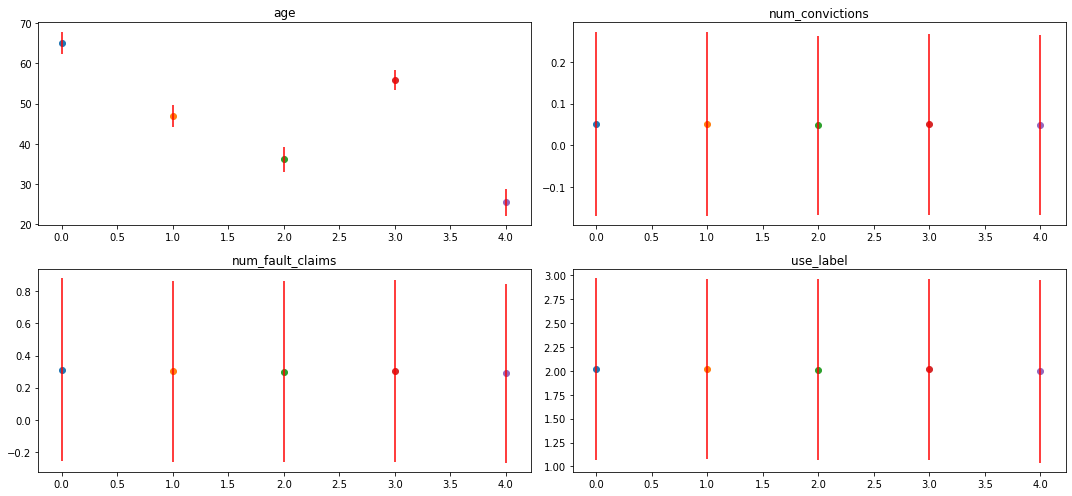

In [12]:
#axis = ("ax1","ax2","ax3","ax4","ax5","ax6","ax7","ax8","ax9","ax10")
fig, axis = plt.subplots(2,2,figsize=(15,7))
for i in range(5):
    new_group = groups[groups["group"] == i]
    f = 0
    for ax in axis.flat:
        feature = new_group[new_group["feature"]==features[f]]
        ax.scatter(i, feature["mean"])
        ax.set_title(features[f])
        ax.errorbar(i, feature["mean"], yerr= feature["std"], ecolor = "r")
        f=f+1
plt.tight_layout()

In [12]:
res

,group,feature,mean,std,num_clusters
0,0,age,38.236004,3.284668,5
1,0,make_ranking,7.307135,4.359234,5
2,0,channel_label,3.468277,2.222483,5
3,1,age,46.852140,2.629479,7
4,1,make_ranking,5.514105,2.831400,7
5,1,channel_label,3.497568,2.259173,7
6,5,age,39.477041,2.261015,9
7,5,make_ranking,5.140306,2.502716,9
8,5,channel_label,3.489796,2.221828,9
9,4,age,24.119950,2.799681,11


In [13]:
covtest = pd.DataFrame()
for f in features:
    toadd = res[res["feature"] == f].loc[:,"mean"]
    toadd = toadd.reset_index(drop=True)
    covtest[f] = toadd
    
covtest = covtest.astype(float)
covtest.cov()

,age,make_ranking,channel_label
age,71.776884,2.341973,0.054026
make_ranking,2.341973,0.913518,-0.001165
channel_label,0.054026,-0.001165,0.001164


In [43]:
covtest3 = covtest*3
print(covtest)
concat_covs = pd.concat([covtest, covtest3])
print(concat_covs.groupby(level=0))
average_covmat = concat_covs.groupby(level=0).mean()
print(average_covmat)

         age  make_ranking  channel_label
0  38.236004      7.307135       3.468277
1  46.852140      5.514105       3.497568
2  39.477041      5.140306       3.489796
3  24.119950      5.051585       3.497203
4  32.615915      5.126495       3.416743
         age  make_ranking  channel_label
0  76.472009     14.614270       6.936553
1  93.704280     11.028210       6.995136
2  78.954082     10.280612       6.979592
3  48.239901     10.103170       6.994406
4  65.231831     10.252990       6.833487
         age  make_ranking  channel_label
0  76.472009     14.614270       6.936553
1  93.704280     11.028210       6.995136
2  78.954082     10.280612       6.979592
3  48.239901     10.103170       6.994406
4  65.231831     10.252990       6.833487


In [105]:
#final function that puts everything together - returns average covariance matrix for significant clusters 
#when comparing input city to rest of uk

def significant_covariance(city, features, regions_to_compare, range_num_centroids, cutoff, num_iterations, plot = False):
    df_bris = data_adapt(df, city)
    #define first covariance matrix
    significant_clusters = group_and_city_comparisons(df_bris, regions_to_compare, features, 
                                                      range_num_centroids, cutoff, prints = False)
    print(significant_clusters)
    if plot == True:
        fig, (ax1) = plt.subplots(1,1,figsize=(15,7))
        ax1.set(ylim=(0, 4), xlim=(18, 70))
        ax1.set_title("Most Relevant Clusters in 10 iterations", fontsize = 16)
        ax1.set_xlabel("Age", fontsize = 12)
        ax1.set_ylabel("Use of vehicle", fontsize = 12)
        plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
        groups_in_clusters =  significant_clusters.loc[:, "group"]
        groups_in_clusters = groups_in_clusters.drop_duplicates() 
        groups_rep = [significant_clusters[significant_clusters['group']==i] for i in groups_in_clusters]
        for group in groups_rep:
            group = group.set_index("feature")
            ax1.errorbar(group.loc["age", "mean"],group.loc["use_label", "mean"],
                         yerr= pd.to_numeric(group.loc["use_label", "std"]), xerr = pd.to_numeric(group.loc["age", "std"]),
                        ecolor = "r")
            ax1.plot(group.loc["age", "mean"],group.loc["use_label", "mean"], "ko")
                    
    average_covmat = pd.DataFrame()
    for f in features:
        toadd = significant_clusters[significant_clusters["feature"] == f].loc[:,"mean"]
        toadd = toadd.reset_index(drop=True)
        average_covmat[f] = toadd
    
    average_covmat = average_covmat.astype(float)
    print(average_covmat)
    average_covmat = average_covmat.cov()
    print("initial mat")
    print(average_covmat)
    #iterate and calculate averages on the go
    for it in range(num_iterations-1):
        significant_clusters = group_and_city_comparisons(df_bris, regions_to_compare, features, 
                                                      range_num_centroids, cutoff, prints = False, plot = False)
        print(significant_clusters)
        if len(significant_clusters)>1:
            print(it)
            if plot == True:
                groups_in_clusters =  significant_clusters.loc[:, "group"]
                groups_in_clusters = groups_in_clusters.drop_duplicates() 
                groups_rep = [significant_clusters[significant_clusters['group']==i] for i in groups_in_clusters]
                for group in groups_rep:
                    group = group.set_index("feature")
                    ax1.errorbar(group.loc["age", "mean"],group.loc["use_label", "mean"],
                             yerr= pd.to_numeric(group.loc["use_label", "std"]), xerr = pd.to_numeric(group.loc["age", "std"]),
                                ecolor = "r")
                    ax1.plot(group.loc["age", "mean"],group.loc["use_label", "mean"], "ko")
    
            new_covmat = pd.DataFrame()
            for f in features:
                toadd = significant_clusters[significant_clusters["feature"] == f].loc[:,"mean"]
                toadd = toadd.reset_index(drop=True)
                new_covmat[f] = toadd
            new_covmat = new_covmat.astype(float)
            new_covmat = new_covmat.cov()
            concat_covs = pd.concat([average_covmat, new_covmat])
            average_covmat = concat_covs.groupby(level=0, sort=False).mean()
    
    return average_covmat
    
    
    

18.0
16.0
  group       feature       mean       std  num_clusters
0     4           age  38.233641  3.282557             5
1     4  make_ranking   7.308520  4.358912             5
2     3           age  34.635955  3.937963             9
3     3  make_ranking  14.056180  2.381649             9
         age  make_ranking
0  38.233641       7.30852
1  34.635955      14.05618
initial mat
                    age  make_ranking
age            6.471671    -12.137980
make_ranking -12.137980     22.765456
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
18.0
16.0
  group       feature       mean       std  num_clusters
0     2           age  38.233641  3.282557             5
1     2  make_ranking   7.308520  4.358912             5
2     1           age  34.635955  3.937963             9
3     1  make_ranking  14.056180  2.381649             9
2
Empty DataFrame
Columns: []
Index: []
16.0
  group       feature       mean       std  num_clusters
0     1           age  34

C:\Users\elena\Anaconda3\lib\site-packages\pandas\core\frame.py:7639: RuntimeWarning: Degrees of freedom <= 0 for slice
  baseCov = np.cov(mat.T)
C:\Users\elena\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\elena\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


16.0
  group       feature       mean       std  num_clusters
0     7           age  34.635955  3.937963             9
1     7  make_ranking  14.056180  2.381649             9
5


C:\Users\elena\Anaconda3\lib\site-packages\pandas\core\frame.py:7639: RuntimeWarning: Degrees of freedom <= 0 for slice
  baseCov = np.cov(mat.T)
C:\Users\elena\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\elena\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Empty DataFrame
Columns: []
Index: []
18.0
16.0
  group       feature       mean       std  num_clusters
0     1           age  38.233641  3.282557             5
1     1  make_ranking   7.308520  4.358912             5
2     0           age  34.635955  3.937963             9
3     0  make_ranking  14.056180  2.381649             9
7
Empty DataFrame
Columns: []
Index: []


,age,make_ranking
age,6.471671,-12.137980
make_ranking,-12.137980,22.765456


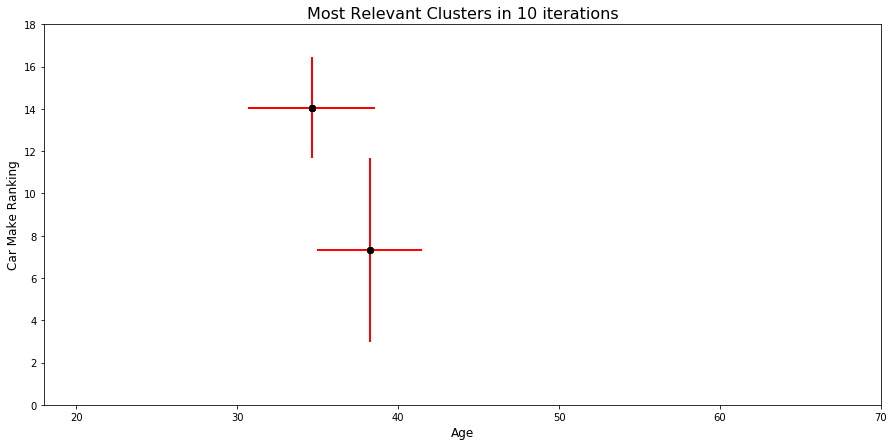

In [46]:
features = np.array(["age", "make_ranking"])
regions_to_compare = ["LONDON", "MANCHESTER", "LIVERPOOL", "NOTTINGHAM", "BIRMINGHAM"]
range_num_centroids = [5,9]
cutoff = "05/01/2019 00:00"
significant_covariance("BRISTOL", features, regions_to_compare, range_num_centroids, cutoff, 10, plot = True)

3
         age  make_ranking
0  38.232104      7.308520
1  34.573978     13.976952
2  40.042416      5.370597
initial mat
                    age  make_ranking
age            7.760488    -12.494254
make_ranking -12.494254     20.382146
0
1


C:\Users\elena\Anaconda3\lib\site-packages\pandas\core\frame.py:7639: RuntimeWarning: Degrees of freedom <= 0 for slice
  baseCov = np.cov(mat.T)
C:\Users\elena\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\elena\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


3
4
5
6


C:\Users\elena\Anaconda3\lib\site-packages\pandas\core\frame.py:7639: RuntimeWarning: Degrees of freedom <= 0 for slice
  baseCov = np.cov(mat.T)
C:\Users\elena\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\elena\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


7


C:\Users\elena\Anaconda3\lib\site-packages\pandas\core\frame.py:7639: RuntimeWarning: Degrees of freedom <= 0 for slice
  baseCov = np.cov(mat.T)
C:\Users\elena\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\elena\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


8


C:\Users\elena\Anaconda3\lib\site-packages\pandas\core\frame.py:7639: RuntimeWarning: Degrees of freedom <= 0 for slice
  baseCov = np.cov(mat.T)
C:\Users\elena\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\elena\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


,age,make_ranking
age,6.335677,-10.918350
make_ranking,-10.918350,19.163498


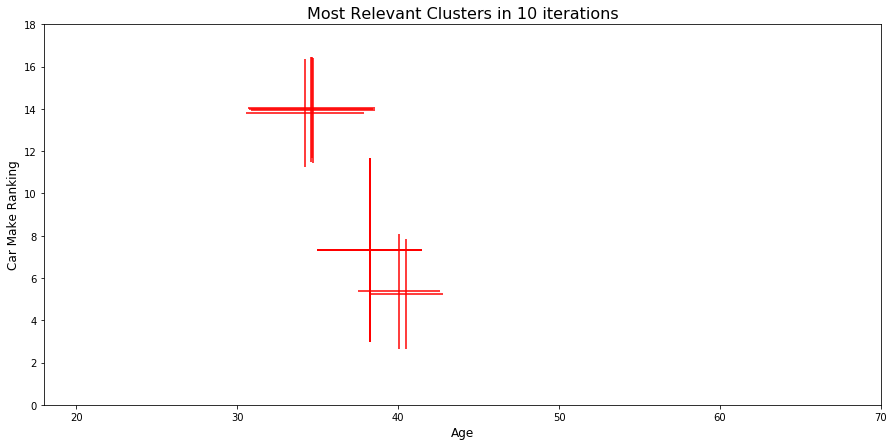

In [28]:
features = np.array(["age", "make_ranking"])
regions_to_compare = ["LONDON", "MANCHESTER", "LIVERPOOL", "NOTTINGHAM", "BIRMINGHAM"]
range_num_centroids = [5,9]

cutoff = "05/01/2019 00:00"
significant_covariance("BRISTOL", features, regions_to_compare, range_num_centroids, cutoff, 10, plot = True)

40.0
24.0
  group             feature       mean       std  num_clusters
0     7        make_ranking   4.374046  0.676690             9
1     7  transmission_label   1.443442  0.496963             9
2     7          fuel_label   1.000000  0.000000             9
3     4        make_ranking  10.719493  0.449425             9
4     4  transmission_label   1.456418  0.498294             9
5     4          fuel_label   1.893819  0.683887             9
   make_ranking  transmission_label  fuel_label
0      4.374046            1.443442    1.000000
1     10.719493            1.456418    1.893819
initial mat
                    make_ranking  transmission_label  fuel_label
make_ranking           20.132349            0.041170    2.835842
transmission_label      0.041170            0.000084    0.005799
fuel_label              2.835842            0.005799    0.399457


KeyboardInterrupt: 

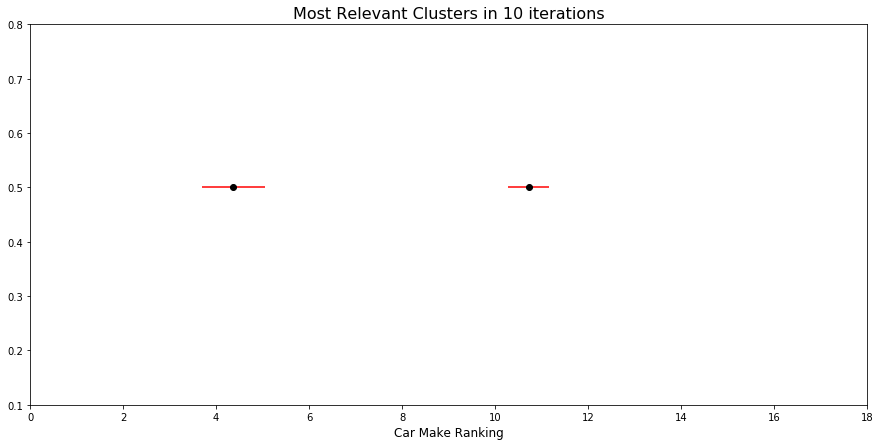

In [87]:
features = ["make_ranking", "transmission_label", "fuel_label"]
regions_to_compare = ["LONDON", "MANCHESTER", "LIVERPOOL", "NOTTINGHAM", "BIRMINGHAM"]
range_num_centroids = [5,9]

cutoff = "05/01/2019 00:00"
significant_covariance("BRISTOL", features, regions_to_compare, range_num_centroids, cutoff, 10, plot = True)

24.0
16.0
   make_ranking  transmission_label  fuel_label
0     10.719493            1.456418    1.893819
1      6.390302            1.448847    2.566529
initial mat
                    make_ranking  transmission_label  fuel_label
make_ranking            9.370949            0.016389   -1.456144
transmission_label      0.016389            0.000029   -0.002547
fuel_label             -1.456144           -0.002547    0.226269
24.0
20.0
  group             feature       mean       std  num_clusters
0     6        make_ranking  10.719493  0.449425             9
1     6  transmission_label   1.456418  0.498294             9
2     6          fuel_label   1.893819  0.683887             9
3     8        make_ranking   1.770306  0.677169             9
4     8  transmission_label   1.436681  0.496191             9
5     8          fuel_label   1.000000  0.000000             9
0
24.0
20.0
  group             feature       mean       std  num_clusters
0     1        make_ranking  10.719493  0.449425

C:\Users\elena\Anaconda3\lib\site-packages\pandas\core\frame.py:7639: RuntimeWarning: Degrees of freedom <= 0 for slice
  baseCov = np.cov(mat.T)
C:\Users\elena\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\elena\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


40.0
20.0
  group             feature      mean       std  num_clusters
0     5        make_ranking  4.374046  0.676690             9
1     5  transmission_label  1.443442  0.496963             9
2     5          fuel_label  1.000000  0.000000             9
3     6        make_ranking  6.904969  0.644917             9
4     6  transmission_label  1.454228  0.498118             9
5     6          fuel_label  3.000000  0.000000             9
6
24.0
17.0
  group             feature       mean       std  num_clusters
0     4        make_ranking  10.719493  0.449425             9
1     4  transmission_label   1.456418  0.498294             9
2     4          fuel_label   1.893819  0.683887             9
3     8        make_ranking   3.974816  0.654799             9
4     8  transmission_label   1.232424  0.422489             9
5     8          fuel_label   1.409234  0.491822             9
7
24.0
  group             feature       mean       std  num_clusters
0     1        make_ranking  10.7

C:\Users\elena\Anaconda3\lib\site-packages\pandas\core\frame.py:7639: RuntimeWarning: Degrees of freedom <= 0 for slice
  baseCov = np.cov(mat.T)
C:\Users\elena\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\elena\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


,make_ranking,transmission_label,fuel_label
make_ranking,14.734762,0.394584,1.791363
transmission_label,0.394584,0.012721,0.034236
fuel_label,1.791363,0.034236,0.707234


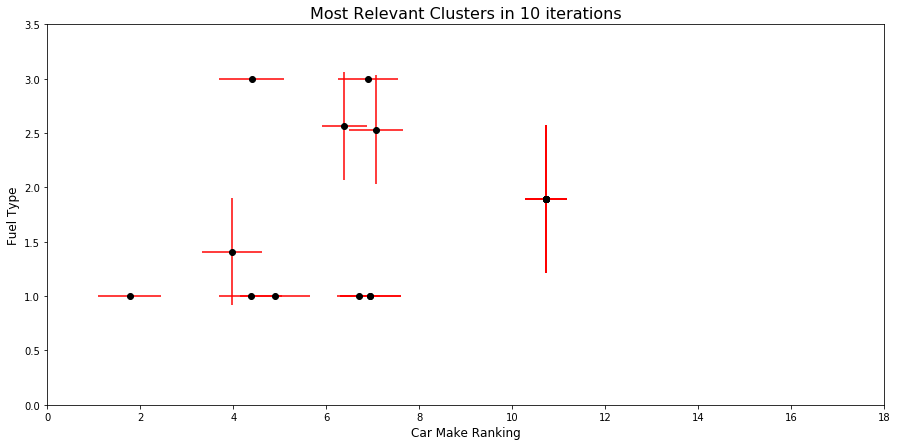

In [43]:
features = ["make_ranking", "transmission_label", "fuel_label"]
regions_to_compare = ["LONDON", "MANCHESTER", "LIVERPOOL", "NOTTINGHAM", "BIRMINGHAM"]
range_num_centroids = [5,9]

cutoff = "05/01/2019 00:00"
significant_covariance("BRISTOL", features, regions_to_compare, range_num_centroids, cutoff, 10, plot = True)

17.0
22.0
20.0
  group       feature       mean       std  num_clusters
0     4  make_ranking   4.930654  0.760364             5
1     6  make_ranking  10.719493  0.449425             9
2     8  make_ranking  15.000000  0.000000             9
   make_ranking
0      4.930654
1     10.719493
2     15.000000
initial mat
              make_ranking
make_ranking     25.537519
17.0
25.0
20.0
  group       feature       mean       std  num_clusters
0     3  make_ranking   4.930654  0.760364             5
1     8  make_ranking  13.000000  0.000000             9
2     7  make_ranking  15.000000  0.000000             9
0
17.0
22.0
20.0
  group       feature       mean       std  num_clusters
0     4  make_ranking   4.930654  0.760364             5
1     2  make_ranking  10.719493  0.449425             9
2     8  make_ranking   7.000000  0.000000             9
1
17.0
25.0
20.0
  group       feature       mean       std  num_clusters
0     1  make_ranking   4.930654  0.760364             5
1     8 

C:\Users\elena\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in greater
C:\Users\elena\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in less


35.0
22.0
  group       feature       mean       std  num_clusters
0     1  make_ranking   4.930654  0.760364             5
1     8  make_ranking   5.000000  0.000000             9
2     6  make_ranking  10.719493  0.449425             9
4
17.0
35.0
22.0
  group       feature       mean       std  num_clusters
0     0  make_ranking   4.930654  0.760364             5
1     8  make_ranking   5.000000  0.000000             9
2     7  make_ranking  10.719493  0.449425             9
5
17.0


C:\Users\elena\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in greater
C:\Users\elena\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in less


22.0
20.0
  group       feature       mean       std  num_clusters
0     0  make_ranking   4.930654  0.760364             5
1     5  make_ranking  10.719493  0.449425             9
2     8  make_ranking   7.000000  0.000000             9
6
17.0


C:\Users\elena\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in greater
C:\Users\elena\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in less


35.0
22.0
  group       feature       mean       std  num_clusters
0     1  make_ranking   4.930654  0.760364             5
1     7  make_ranking   5.000000  0.000000             9
2     8  make_ranking  10.719493  0.449425             9
7
17.0
22.0
20.0
  group       feature       mean       std  num_clusters
0     1  make_ranking   4.930654  0.760364             5
1     8  make_ranking  10.719493  0.449425             9
2     4  make_ranking   7.000000  0.000000             9
8


,make_ranking
make_ranking,9.538778


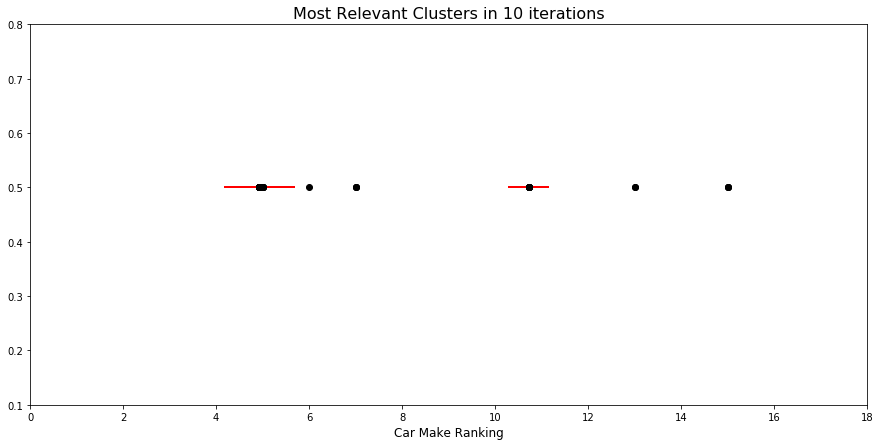

In [101]:
features = ["make_ranking"]
            
regions_to_compare = ["LONDON", "MANCHESTER", "LIVERPOOL", "NOTTINGHAM", "BIRMINGHAM"]
range_num_centroids = [5,9]

cutoff = "05/01/2019 00:00"
significant_covariance("BRISTOL", features, regions_to_compare, range_num_centroids, cutoff, 10, plot = True)

16.0
  group           feature       mean       std  num_clusters
0     1               age  36.167163  3.120116             5
1     1         use_label   2.012612  0.947511             5
2     1   num_convictions   0.048154  0.214116             5
3     1  num_fault_claims   0.299931  0.561308             5
         age  use_label  num_convictions  num_fault_claims
0  36.167163   2.012612         0.048154          0.299931
initial mat
                  age  use_label  num_convictions  num_fault_claims
age               NaN        NaN              NaN               NaN
use_label         NaN        NaN              NaN               NaN
num_convictions   NaN        NaN              NaN               NaN
num_fault_claims  NaN        NaN              NaN               NaN


C:\Users\elena\Anaconda3\lib\site-packages\pandas\core\frame.py:7639: RuntimeWarning: Degrees of freedom <= 0 for slice
  baseCov = np.cov(mat.T)
C:\Users\elena\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\elena\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


16.0
17.0
16.0
   group           feature       mean       std  num_clusters
0      1               age  36.167163  3.120116             5
1      1         use_label   2.012612  0.947511             5
2      1   num_convictions   0.048154  0.214116             5
3      1  num_fault_claims   0.299931  0.561308             5
4      2               age  45.778309  1.637831             9
5      2         use_label   2.022010  0.943774             9
6      2   num_convictions   0.052632  0.223333             9
7      2  num_fault_claims   0.306539  0.568930             9
8      7               age  39.431348  1.687539             9
9      7         use_label   2.017370  0.948241             9
10     7   num_convictions   0.052936  0.223953             9
11     7  num_fault_claims   0.287014  0.553625             9
0
16.0
17.0
16.0
   group           feature       mean       std  num_clusters
0      3               age  36.167163  3.120116             5
1      3         use_label   2.012612 

C:\Users\elena\Anaconda3\lib\site-packages\pandas\core\frame.py:7639: RuntimeWarning: Degrees of freedom <= 0 for slice
  baseCov = np.cov(mat.T)
C:\Users\elena\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\elena\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


16.0
16.0
  group           feature       mean       std  num_clusters
0     1               age  36.167163  3.120116             5
1     1         use_label   2.012612  0.947511             5
2     1   num_convictions   0.048154  0.214116             5
3     1  num_fault_claims   0.299931  0.561308             5
4     3               age  40.923586  1.411786             9
5     3         use_label   2.002038  0.943347             9
6     3   num_convictions   0.056037  0.230051             9
7     3  num_fault_claims   0.282221  0.548211             9
6
16.0
17.0
  group           feature       mean       std  num_clusters
0     4               age  36.167163  3.120116             5
1     4         use_label   2.012612  0.947511             5
2     4   num_convictions   0.048154  0.214116             5
3     4  num_fault_claims   0.299931  0.561308             5
4     0               age  40.425613  1.691717             9
5     0         use_label   2.007608  0.946757             9
6 

,age,use_label,num_convictions,num_fault_claims
age,10.366372,-0.011883,0.016025,-0.020102
use_label,-0.011883,0.000020,-0.000022,0.000033
num_convictions,0.016025,-0.000022,0.000029,-0.000040
num_fault_claims,-0.020102,0.000033,-0.000040,0.000062


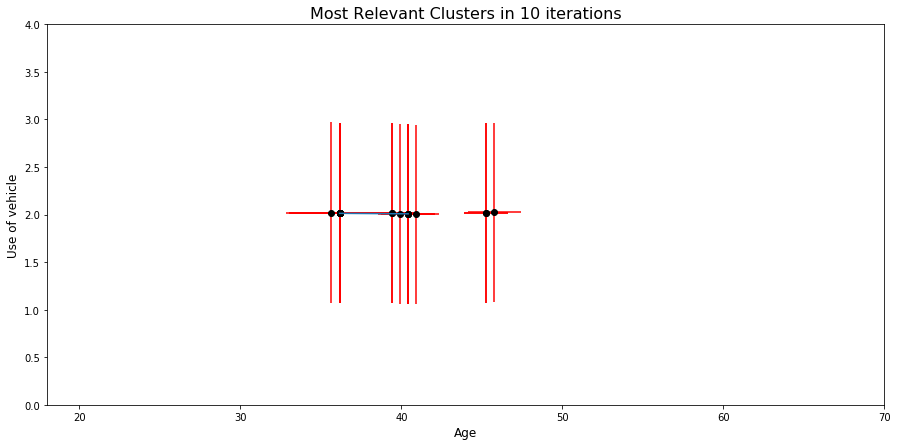

In [106]:
features = ["age", "use_label", "num_convictions", "num_fault_claims"]
            
regions_to_compare = ["LONDON", "MANCHESTER", "LIVERPOOL", "NOTTINGHAM", "BIRMINGHAM"]
range_num_centroids = [5,9]

cutoff = "05/01/2019 00:00"
significant_covariance("BRISTOL", features, regions_to_compare, range_num_centroids, cutoff, 10, plot = True)

19.0
21.0
17.0
   group           feature       mean       std  num_clusters
0      1               age  35.639878  2.823209             5
1      1         use_label   2.019583  0.948629             5
2      1   num_convictions   0.046541  0.210681             5
3      1  num_fault_claims   0.299084  0.557157             5
4      3               age  39.946867  1.389957             9
5      3         use_label   2.007519  0.948759             9
6      3   num_convictions   0.056140  0.230250             9
7      3  num_fault_claims   0.288221  0.559083             9
8      8               age  45.248123  1.365032             9
9      8         use_label   2.013038  0.945672             9
10     8   num_convictions   0.051758  0.221582             9
11     8  num_fault_claims   0.305808  0.565582             9
         age  use_label  num_convictions  num_fault_claims
0  35.639878   2.019583         0.046541          0.299084
1  39.946867   2.007519         0.056140          0.288221
2 

C:\Users\elena\Anaconda3\lib\site-packages\pandas\core\frame.py:7639: RuntimeWarning: Degrees of freedom <= 0 for slice
  baseCov = np.cov(mat.T)
C:\Users\elena\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\elena\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


16.0
17.0
  group           feature       mean       std  num_clusters
0     3               age  36.167163  3.120116             5
1     3         use_label   2.012612  0.947511             5
2     3   num_convictions   0.048154  0.214116             5
3     3  num_fault_claims   0.299931  0.561308             5
4     5               age  40.425613  1.691717             9
5     5         use_label   2.007608  0.946757             9
6     5   num_convictions   0.055790  0.229565             9
7     5  num_fault_claims   0.290363  0.556157             9
2
19.0
21.0
17.0
   group           feature       mean       std  num_clusters
0      1               age  35.639878  2.823209             5
1      1         use_label   2.019583  0.948629             5
2      1   num_convictions   0.046541  0.210681             5
3      1  num_fault_claims   0.299084  0.557157             5
4      8               age  39.946867  1.389957             9
5      8         use_label   2.007519  0.948759     

C:\Users\elena\Anaconda3\lib\site-packages\pandas\core\frame.py:7639: RuntimeWarning: Degrees of freedom <= 0 for slice
  baseCov = np.cov(mat.T)
C:\Users\elena\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\elena\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


19.0
21.0
17.0
   group           feature       mean       std  num_clusters
0      3               age  35.639878  2.823209             5
1      3         use_label   2.019583  0.948629             5
2      3   num_convictions   0.046541  0.210681             5
3      3  num_fault_claims   0.299084  0.557157             5
4      6               age  39.946867  1.389957             9
5      6         use_label   2.007519  0.948759             9
6      6   num_convictions   0.056140  0.230250             9
7      6  num_fault_claims   0.288221  0.559083             9
8      0               age  45.248123  1.365032             9
9      0         use_label   2.013038  0.945672             9
10     0   num_convictions   0.051758  0.221582             9
11     0  num_fault_claims   0.305808  0.565582             9
6
16.0
17.0
16.0
   group           feature       mean       std  num_clusters
0      0               age  36.167163  3.120116             5
1      0         use_label   2.012612 

C:\Users\elena\Anaconda3\lib\site-packages\pandas\core\frame.py:7639: RuntimeWarning: Degrees of freedom <= 0 for slice
  baseCov = np.cov(mat.T)
C:\Users\elena\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\elena\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


,age,use_label,num_convictions,num_fault_claims
age,21.582711,0.002716,0.011836,0.015200
use_label,0.002716,0.000033,-0.000012,0.000025
num_convictions,0.011836,-0.000012,0.000018,-0.000018
num_fault_claims,0.015200,0.000025,-0.000018,0.000083


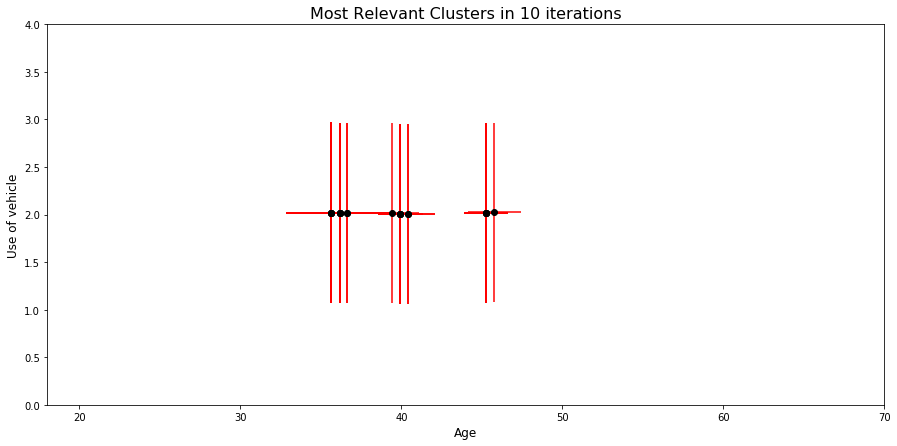

In [107]:
features = ["age", "use_label", "num_convictions", "num_fault_claims"]
            
regions_to_compare = ["LONDON", "MANCHESTER", "LIVERPOOL", "NOTTINGHAM", "BIRMINGHAM"]
range_num_centroids = [5,9]

cutoff = "05/01/2019 00:00"
significant_covariance("BRISTOL", features, regions_to_compare, range_num_centroids, cutoff, 10, plot = True)

In [15]:
covtest = pd.DataFrame()
for f in features:
    toadd = res[res["feature"] == f].loc[:,"mean"]
    toadd = toadd.reset_index(drop=True)
    covtest[f] = toadd
    
covtest = covtest.astype(float)
covtest.cov()

,age,make_ranking,channel_label
age,57.368247,-26.046840,-0.179594
make_ranking,-26.046840,19.110076,0.034569
channel_label,-0.179594,0.034569,0.001267


In [18]:
features = np.array(["age", "make_ranking"])
regions_to_compare = ["LONDON", "MANCHESTER", "LIVERPOOL", "NOTTINGHAM", "BIRMINGHAM"]
range_num_centroids = [5,7,9,11]
res = group_and_city_comparisons(df_bris, regions_to_compare, features, range_num_centroids, "05/01/2019 00:00", prints = False, plot = True)

In [19]:
res

,group,feature,mean,std,num_clusters
0,2,age,37.468584,3.378833,5
1,2,make_ranking,7.423429,4.400881,5
2,3,age,46.765862,2.639567,7
3,3,make_ranking,5.395372,2.740873,7


In [20]:
features = np.array(["age", "make_ranking", "num_convictions", "num_fault_claims", "purchaseyear"])
regions_to_compare = ["LONDON", "MANCHESTER", "LIVERPOOL", "NOTTINGHAM", "BIRMINGHAM"]
range_num_centroids = [5,7,9,11]
res = group_and_city_comparisons(df_bris, regions_to_compare, features, range_num_centroids, "05/01/2019 00:00", prints = False, plot = True)

In [21]:
res

,group,feature,mean,std,num_clusters
0,4,age,38.291603,3.329167,5
1,4,make_ranking,7.287047,4.344618,5
2,4,num_convictions,0.050336,0.218662,5
3,4,num_fault_claims,0.299197,0.561033,5
4,4,purchaseyear,2015.169017,3.806671,5
5,3,age,46.769364,2.640572,7
6,3,make_ranking,5.407398,2.750825,7
7,3,num_convictions,0.050645,0.219300,7
8,3,num_fault_claims,0.298908,0.556273,7
9,3,purchaseyear,2015.100546,3.893169,7


,group,feature,mean,std,num_clusters
0,3,age,38.230854,3.296150,5
1,3,make_ranking,7.221198,4.319876,5
2,3,num_convictions,0.050033,0.218037,5
3,3,num_fault_claims,0.300636,0.562223,5
4,3,purchaseyear,2015.152952,3.816017,5
5,2,age,50.555763,3.698627,5
6,2,make_ranking,4.966504,2.453345,5
7,2,num_convictions,0.048466,0.214768,5
8,2,num_fault_claims,0.298278,0.559495,5
9,2,purchaseyear,2015.055015,3.907834,5


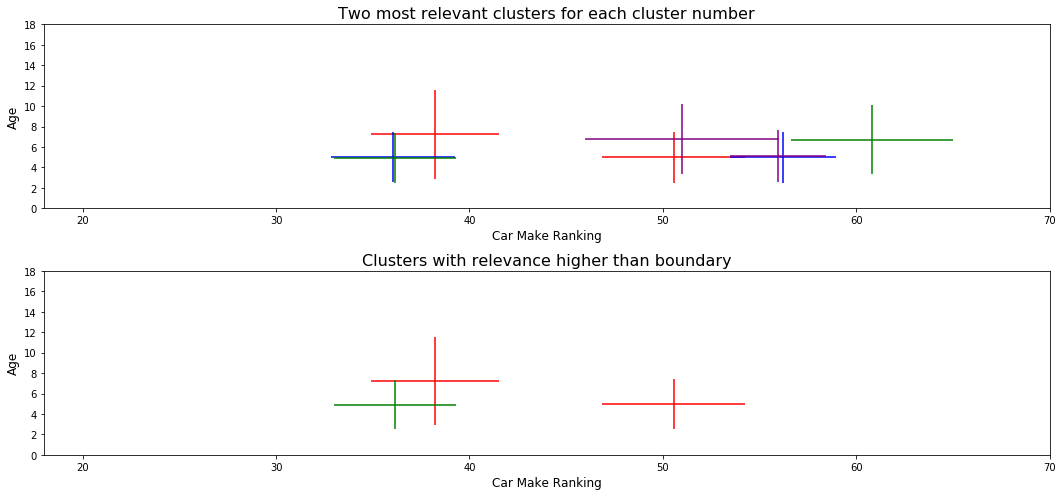

In [265]:
features = np.array(["age", "make_ranking", "num_convictions", "num_fault_claims", "purchaseyear"])
regions_to_compare = ["LONDON", "MANCHESTER", "LIVERPOOL", "NOTTINGHAM", "BIRMINGHAM"]
range_num_centroids = [5,7,9,11]
res = group_and_city_comparisons(df_bris, regions_to_compare, features, range_num_centroids, "05/01/2019 00:00", prints = False, plot = True)
res

In [269]:
for feature in features:
    res_feature = res[res["feature"] == feature]
    feature_mean = np.mean(res_feature["mean"])
    feature_std = np.std(res_feature["mean"])
    print("for feature", feature, "mean is ", feature_mean, "and std is ", feature_std)

for feature age mean is  41.648344315471114 and std is  6.355068142053113
for feature make_ranking mean is  5.703420920284721 and std is  1.0733805108412835
for feature num_convictions mean is  0.04792005142622804 and std is  0.001985680792943062
for feature num_fault_claims mean is  0.29970899692433833 and std is  0.0010262727715099173
for feature purchaseyear mean is  2015.493060960199 and std is  0.5516897171926014
